自定义数据集

In [2]:
import os
import random
demoset = os.listdir('./data/demonstration')
demoset.sort()
train_index_file = open('./data/train.txt','w')
valid_index_file = open('./data/valid.txt','w')

for demo in demoset:
    if random.uniform(0,1) > 0.1:
        train_index_file.write('./data/demonstration/'+demo+' '+demo[-5]+'\n')
    else:
        valid_index_file.write('./data/demonstration/'+demo+' '+demo[-5]+'\n')
train_index_file.close()
valid_index_file.close()


In [3]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
from PIL import Image


class  SelfCustomDataset(Dataset):
    def __init__(self, label_file):
        with open(label_file, 'r') as f:
            self.imgs = list(map(lambda line: line.strip().split(' '), f))
        self.transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])

    def __getitem__(self, index):
#         try:
#             img_path,action = self.imgs[index]
#         except:
#             print(self.imgs[index])
#             raise
#         img_path,action = self.imgs[index]
#         img = Image.open(img_path).convert('RGB')
#         img = img.resize((128,128))
#         img = np.asarray(img) / 255.0
        img_path,action = self.imgs[index]
        img = cv2.imread(img_path)
        img = cv2.resize(img,(128,128))
        img = img/255.
        img =self.transform(img)
        return img, torch.from_numpy(np.array(int(action)))
 
    def __len__(self):
        return len(self.imgs)


train_datasets = SelfCustomDataset('./data/train.txt')
trainloader = torch.utils.data.DataLoader(train_datasets, batch_size=32, shuffle=True, num_workers=1)

test_datasets = SelfCustomDataset('./data/valid.txt')
testloader = torch.utils.data.DataLoader(test_datasets, batch_size=32, shuffle=True, num_workers=1)

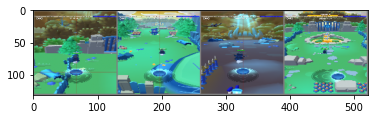

right forward forward forward


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images[:4]))
classes = ('shoot','forward','left','right','backwardS')
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


引入分类模型

In [5]:
from torchvision.models import mobilenet_v2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=mobilenet_v2(pretrained=False,num_classes=5).to(device)

引入优化器和损失函数

In [6]:
import torch.optim as optim
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

训练过程

In [7]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.float()
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 19))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 1.274
[1,    40] loss: 1.214
[2,    20] loss: 0.963
[2,    40] loss: 0.982
[3,    20] loss: 0.816
[3,    40] loss: 0.885
[4,    20] loss: 0.677
[4,    40] loss: 0.724
[5,    20] loss: 0.518
[5,    40] loss: 0.662
[6,    20] loss: 0.547
[6,    40] loss: 0.496
[7,    20] loss: 0.359
[7,    40] loss: 0.502
[8,    20] loss: 0.372
[8,    40] loss: 0.442
[9,    20] loss: 0.320
[9,    40] loss: 0.383
[10,    20] loss: 0.274
[10,    40] loss: 0.307
[11,    20] loss: 0.270
[11,    40] loss: 0.294
[12,    20] loss: 0.204
[12,    40] loss: 0.289
[13,    20] loss: 0.265
[13,    40] loss: 0.387
[14,    20] loss: 0.215
[14,    40] loss: 0.242
[15,    20] loss: 0.210
[15,    40] loss: 0.245
[16,    20] loss: 0.210
[16,    40] loss: 0.201
[17,    20] loss: 0.252
[17,    40] loss: 0.270
[18,    20] loss: 0.170
[18,    40] loss: 0.156
[19,    20] loss: 0.097
[19,    40] loss: 0.121
[20,    20] loss: 0.207
[20,    40] loss: 0.249
[21,    20] loss: 0.159
[21,    40] loss: 0.113
[22,    20

保存模型

In [101]:
PATH = './model/1_1_BC.pth'
torch.save(model.state_dict(), PATH)

测试

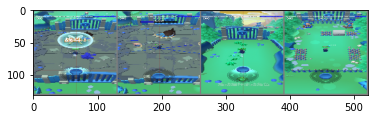

GroundTruth:  shoot backwardS forward forward
Predicted:  shoot shoot forward forward


In [102]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

test_model = mobilenet_v2(pretrained=False,num_classes=5).to(device)
test_model.load_state_dict(torch.load(PATH))
test_model.eval()
outputs = test_model(images.float().to(device))
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]for j in range(4)))

批量测试

In [110]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.float()
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = test_model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 69 %


In [111]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.float()
        images = images.to(device)
        labels = labels.to(device)
        outputs = test_model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,accuracy))

Accuracy for class shoot is: 73.4 %
Accuracy for class forward is: 81.2 %
Accuracy for class left  is: 12.5 %
Accuracy for class right is: 35.0 %
Accuracy for class backwardS is: 0.0 %


In [116]:
import cv2
img = cv2.imread('data/demonstration/2021-07-27-19-40-39-147_3.png')
img = cv2.resize(img,(128,128))
img = np.asarray(img) / 255.0
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
img = transform(img).float().to(device)
img = torch.unsqueeze(img, 0)
output = test_model(img)
print(output)

tensor([[-0.3716, -3.7348, -6.4257,  6.1107, -5.7318]], device='cuda:0',
       grad_fn=<AddmmBackward>)
